In [1]:
import torch, os
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset # "ConcatDataset" and "Subset" are possibly useful.
cfg = {
    'dataset_root': './food11-hw13',
    'batch_size': 256,
}

teacher_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False, num_classes=11)
# load state dict
teacher_ckpt_path = os.path.join(cfg['dataset_root'], "resnet18_teacher.ckpt")
teacher_model.load_state_dict(torch.load(teacher_ckpt_path, map_location='cuda'))

Using cache found in /home/lpz106u/.cache/torch/hub/pytorch_vision_v0.10.0


<All keys matched successfully>

In [2]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# define training/testing transforms
test_tfm = transforms.Compose([
    # It is not encouraged to modify this part if you are using the provided teacher model. This transform is stardard and good enough for testing.
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])
class FoodDataset(Dataset):
    def __init__(self, path, tfm=test_tfm, files = None):
        super().__init__()
        self.path = path
        self.files = sorted([os.path.join(path,x) for x in os.listdir(path) if x.endswith(".jpg")])
        if files != None:
            self.files = files
        print(f"One {path} sample",self.files[0])
        self.transform = tfm
  
    def __len__(self):
        return len(self.files)
  
    def __getitem__(self,idx):
        fname = self.files[idx]
        im = Image.open(fname)
        im = self.transform(im)
        try:
            label = int(fname.split("/")[-1].split("_")[0])
        except:
            label = -1 # test has no label
        return im,label

valid_set = FoodDataset(os.path.join(cfg['dataset_root'], "validation"), tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=cfg['batch_size'], shuffle=False, num_workers=10, pin_memory=False)

One ./food11-hw13/validation sample ./food11-hw13/validation/0_0.jpg


In [3]:
import torch.nn.utils.prune as prune
from torch import nn
import copy, time
from tqdm import tqdm

device = 'cuda'

def prune_model(model: nn.Module, ratio: float, valid_loader: DataLoader):
    model = copy.deepcopy(model)
    if ratio > 0:
        for name, module in model.named_modules():
            if isinstance(module, torch.nn.Conv2d): # if the nn.module is torch.nn.Conv2d
                prune.l1_unstructured(module, name='weight', amount=ratio)
    model.eval()
    start = time.time()
    correct_cnt = 0
    tot_cnt = 0
    for batch in tqdm(valid_loader, leave=False):
        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs)
        # Compute the accuracy for current batch.
        correct_cnt += (logits.argmax(dim=-1) == labels).sum().item()
        # Record the loss and accuracy.
        tot_cnt += imgs.shape[0]
    
    return correct_cnt / tot_cnt, time.time() - start

accs, infer_secs = [], []
pbar = tqdm(torch.arange(0.0, 1, 0.05))
for ratio in pbar:
    acc, infer_sec = prune_model(teacher_model.to(device), ratio.item(), valid_loader)
    pbar.set_postfix({'ratio': ratio.item(), 'acc': acc, 'infer_time': infer_sec})
    accs.append(acc)
    infer_secs.append(infer_sec)

100%|██████████| 20/20 [02:49<00:00,  8.46s/it, ratio=0.95, acc=0.101, infer_time=8.56]


<AxesSubplot:title={'center':'Pruning Ratio v.s. Accuracy'}, xlabel='Pruning Ratio'>

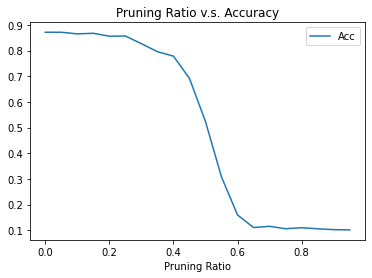

In [6]:
import pandas as pd
df = pd.DataFrame({'Pruning Ratio': torch.arange(0.0, 1, 0.05).detach().tolist(), 'Acc': accs},)
df.set_index('Pruning Ratio', inplace=True)
df.plot(title='Pruning Ratio v.s. Accuracy')

In [7]:
df = pd.DataFrame({'Pruning Ratio': torch.arange(0.0, 1, 0.05).detach().tolist(), 'running times(secs)': infer_secs})
df

,Pruning Ratio,running times(secs)
0,0.00,8.297606
1,0.05,8.297432
2,0.10,8.191583
3,0.15,8.451556
4,0.20,8.222766
5,0.25,8.460672
6,0.30,8.927217
7,0.35,8.640779
8,0.40,8.193166
9,0.45,8.380338
